# K-Nearest Neighbours Wine Quality Classification

By Kevin Chen, Peidong Qin, Allison Luna, and Akshay Tripathi

### Introduction

Wine is a beverage that humans have enjoyed consuming for thousands of years, with evidence of consumption even in ancient China and Georgia, around 6000 B.C. What they consider as wine varies from place to place. Ancient China created wine using honey and fruits, while Georgia used fermented grapes which is closer to what we expect today. As time went on and with the occurrence of the agricultural evolutions, many regions around the world have come to make wine using differing techniques (Lance in Motion, 2017). One of the most common ways wine is judged is based on quality level. Quality level is defined as a measure of how good a wine is, according to experts who take into account aspects such as aging potential, subtlety, and complexity, on a scale from zero to ten (Jackson, 2008). For the purposes of this study, we must also understand certain factors of a wine, such as its fixed acidity. Fixed acidity, otherwise known as nonvolatile acidity, where nonvolatile refers to the category of acids that do not readily evaporate. This study explores if we can predict the quality level of various Portuguese “Vinho Verde” red wines using measurements of their fixed acidity, pH, density, and citric acid level. Past studies have examined this question with similar predictors, most using various machine learning techniques, and few with k-nearest neighbours classification, which is what we will use. These studies have all produced varying results, suggesting the topic should be explored further and methods can still very much be improved upon. Thus, to answer this question, we acquired a tidy dataset from Kaggle named “Wine Quality Dataset” (Yasser, 2022). It includes 1597 rows, each of which represents one type of red wine. It includes 12 variables including quality level, fixed acidity, pH, density, alcohol percentage, and residual sugar amount.

### Method and Results

We plan to use pH, density, fixed acidity, and citric acid as our predictive variables in order to classify the various red wines by their quality level. The data pulled was already clean, so no further tidying was necessary. Based on our analysis using ggpairs to find the correlation between different variables, we found the strongest correlation between pH, density, fixed acidity, and citric acid. In addition, previous studies using classification algorithms and regression analysis showed that pH, density, fixed acidity, and citric acid are good predictors to obtain wine quality (Chiu et al., 2021; Gupta 2018; Laughter et al., 2020)  in addition to other predictors. Specifically, we found the highest correlation values between fixed acidity and pH, fixed acidity and density, and fixed acidity and citric acid. It is also known that pH and density show high correlation values (Rashid, 2015), so we added it in addition to our ggpairs data.


In [61]:
library(repr)
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(GGally)
library(RColorBrewer)

palette('Dark2')

In [9]:
data <- read_csv("https://raw.githubusercontent.com/allisonml/Wine-Data/main/WineQT.csv")
names(data) <- gsub(" ", "_", colnames(data))
    
head(data)

relevant_data <- data %>%
    select(fixed_acidity, citric_acid, density, pH, quality) %>%
    mutate(quality=as_factor(quality))
    
head(relevant_data)

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double(),
  Id = col_double()
)



fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,2
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,3
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,4
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,5


fixed_acidity,citric_acid,density,pH,quality
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.00,0.9978,3.51,5
7.8,0.00,0.9968,3.20,5
7.8,0.04,0.9970,3.26,5
11.2,0.56,0.9980,3.16,6
7.4,0.00,0.9978,3.51,5
7.4,0.00,0.9978,3.51,5


**Fig 1. Correlational Values**

ggpairs was used to find predictors that had high correlation. It is visible that fixed acidity and pH, fixed acidity and density, and fixed acidity and citric acid had the highest correlation values at -0.685, 0.682, and 0.673 respectively.

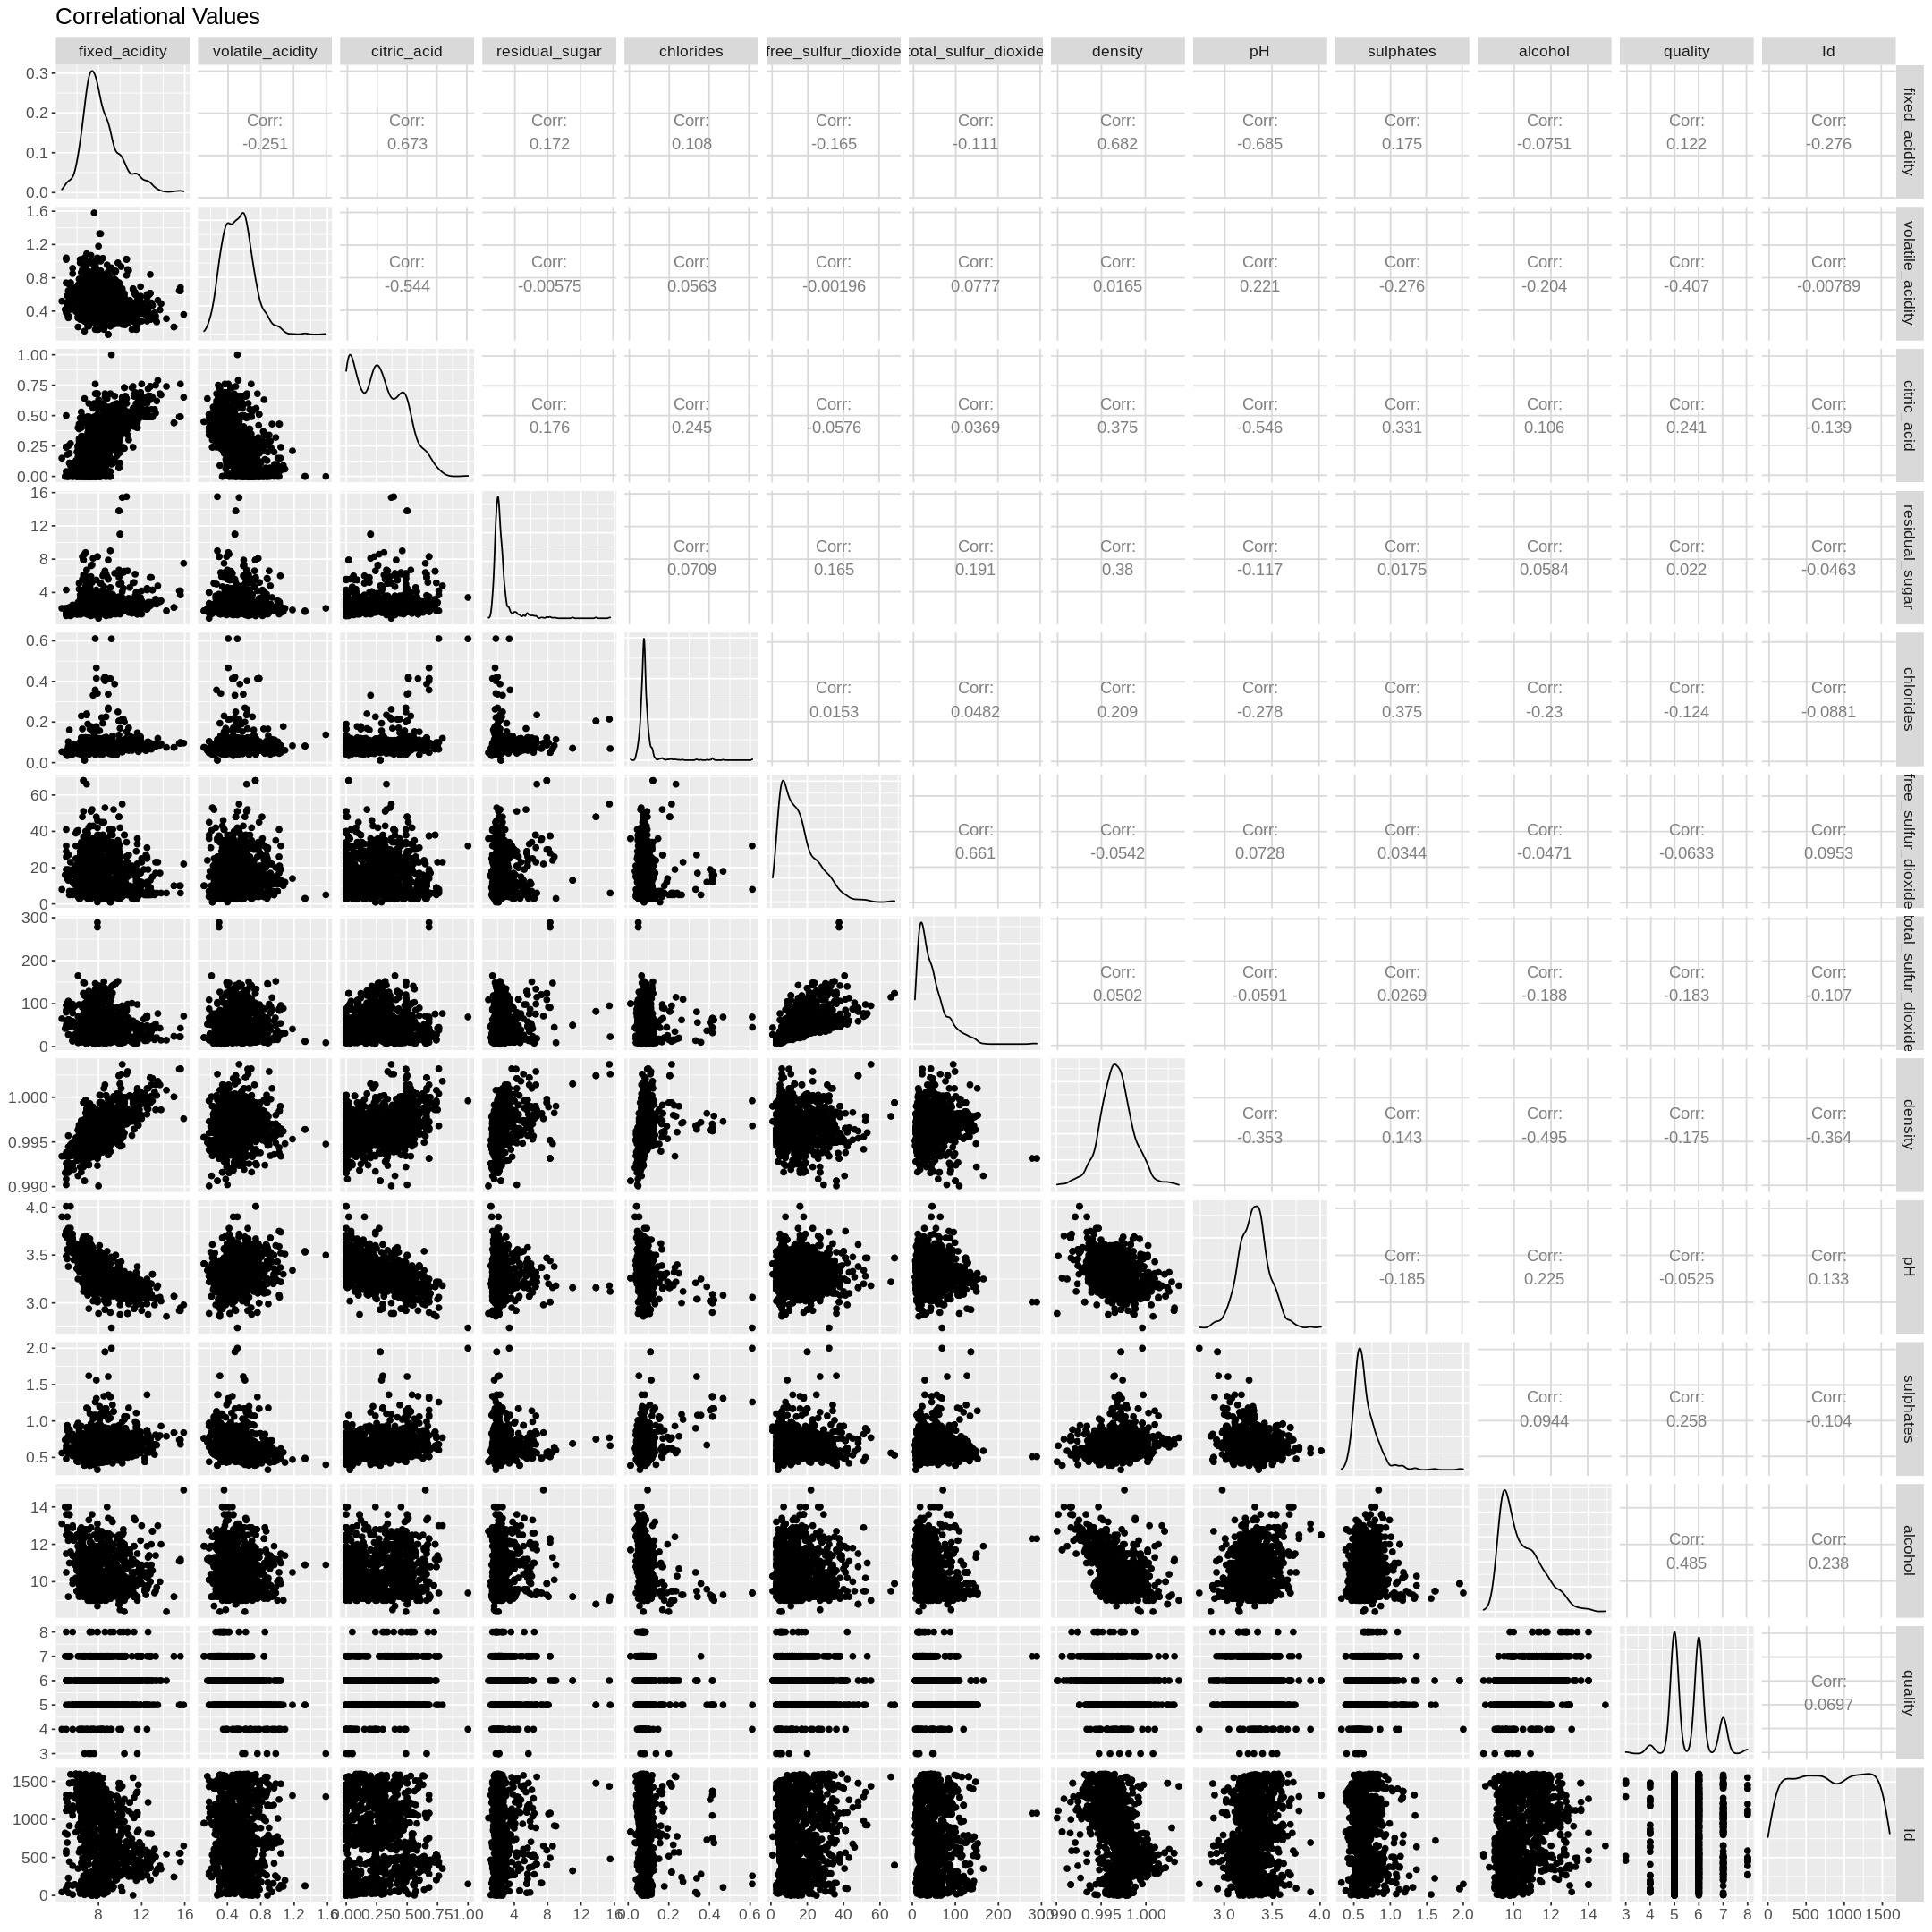

In [56]:
options(repr.plot.width=18, repr.plot.height=18)

correlational_values <- ggpairs(data) +
    theme(text = element_text(size = 13)) +
    ggtitle("Correlational Values")

correlational_values

In order to answer our question, we will use k-nearest neighbours classification. We chose to use classification over regression, as our data only provided quality levels in discrete integers from 3 to 8, which provided very few possible values to predict using regression, despite them being numerical. After loading in our data, we began with a preliminary analysis to explore the data set and observe the mean value of each predictor per class.

**Table 1. Summary of Data Set**

In [39]:
# num of vars, if data is standardized, number of observations, and number of rows missing data in our training data
data_summary <- 
    tibble(num_variables = ncol(relevant_data), 
           standardized = as.factor("No"), 
           total_observations = nrow(training_data),
           rows_missing_data = 0L)

data_summary

num_variables,standardized,total_observations,rows_missing_data
<int>,<fct>,<int>,<int>
5,No,858,0


**Table 2. Predictor Summary**

In [40]:
# mean predictor values and number of observations in each class
class_summary <- relevant_data %>% 
    group_by(quality) %>%
    summarize(num_observations = n(),
              mean_fixed_acidity = mean(fixed_acidity),
              mean_citric_acid = mean(citric_acid),
              mean_density = mean(density),
              mean_pH = mean(pH))

class_summary

`summarise()` ungrouping output (override with `.groups` argument)



quality,num_observations,mean_fixed_acidity,mean_citric_acid,mean_density,mean_pH
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
3,6,8.450000,0.2116667,0.9976817,3.361667
4,33,7.809091,0.1657576,0.9966694,3.391212
5,483,8.161077,0.2401242,0.9970727,3.302091
6,462,8.317749,0.2636797,0.9966095,3.323788
7,143,8.851049,0.3865734,0.9960708,3.287133
8,16,8.806250,0.4325000,0.9955531,3.240625


Then, we proceeded to split our data into a training and testing set. We examined the distribution of the classes in our training data with scatterplots, as well as creating a bar plot to examine the balance of classes in our data.

In [14]:
set.seed(2341)
# split the data into training and testing sets
split_data <- initial_split(relevant_data, prop = 0.75, strata = quality)
training_data <- training(split_data)
testing_data <- testing(split_data)

In [15]:
set.seed(2341)
# split the data into training and testing sets
split_data <- initial_split(relevant_data, prop = 0.75, strata = quality)
training_data <- training(split_data)
testing_data <- testing(split_data)

**Fig 2a. Fixed Acidity VS pH**

Using training data, our analysis showed that fixed acidity and pH has a linear moderate negative relationship at r = -0.685. In general, there does not seem to be a strong connection between quality level when plotted against fixed acidity and pH.

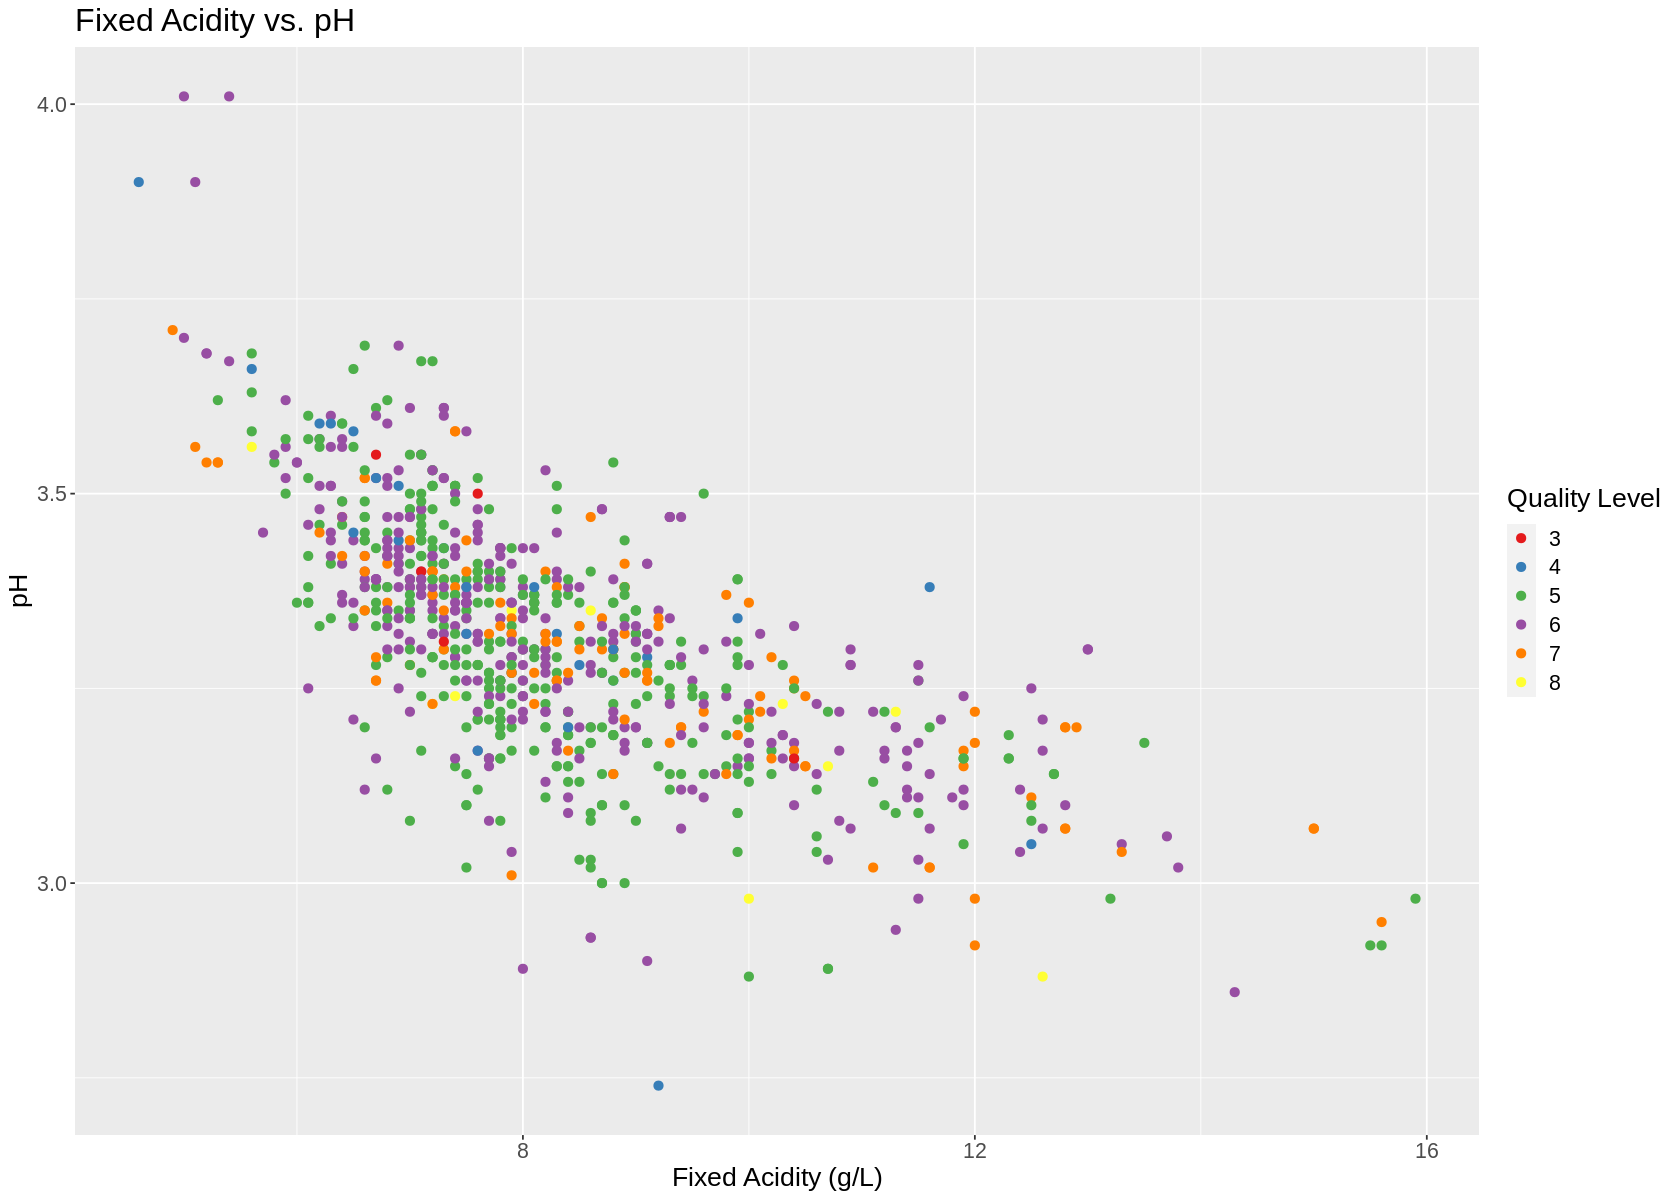

In [62]:
options(repr.plot.width=14, repr.plot.height=10)

# Fixed Acidity vs. pH
fixed_ph_plot <- training_data %>%
    ggplot(aes(x=fixed_acidity, y=pH, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="pH", color = "Quality Level")+
    ggtitle("Fixed Acidity vs. pH")+
    scale_color_brewer(palette = "Set1")

fixed_ph_plot

**Fig 2b. Fixed Acidity VS Density**

Fixed acidity and density seems to have a linear moderate positive relationship at r = 0.682. It is visible that quality levels 5 and 6 seem to hover around higher density levels comparative to quality levels 7 and 8.


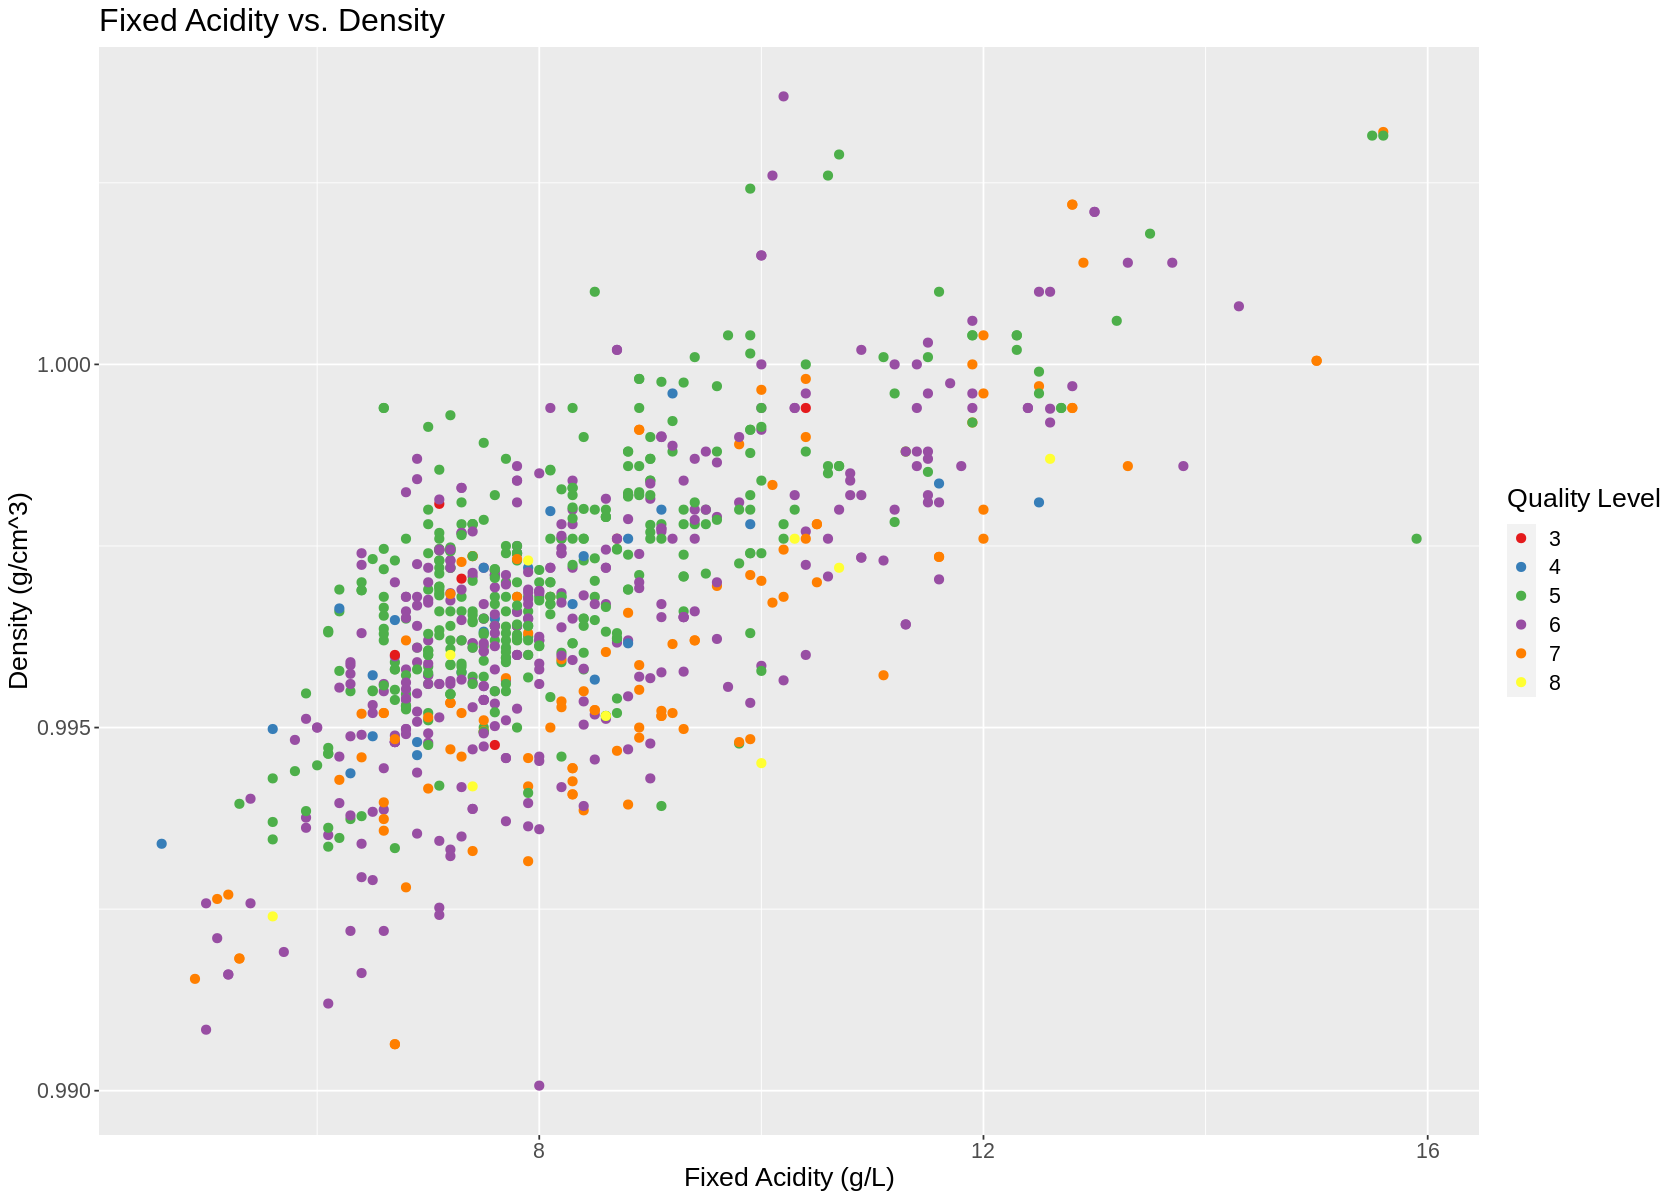

In [59]:
options(repr.plot.width=14, repr.plot.height=10)

# Fixed Acidity vs. Density
fixed_density_plot <- training_data %>%
    ggplot(aes(x=fixed_acidity, y=density, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="Density (g/cm^3)", color = "Quality Level")+
    ggtitle("Fixed Acidity vs. Density")+
    scale_color_brewer(palette = "Set1")

fixed_density_plot

**Fig 2c. Fixed Acidity VS Citric Acid**

Fixed acidity and citric acid seems to have a linear moderate positive relationship at r = 0.673. Although not strong, it does seem like higher quality levels 7 and 8 hover at higher citric acid levels comparative to lower quality levels 4 and 5.


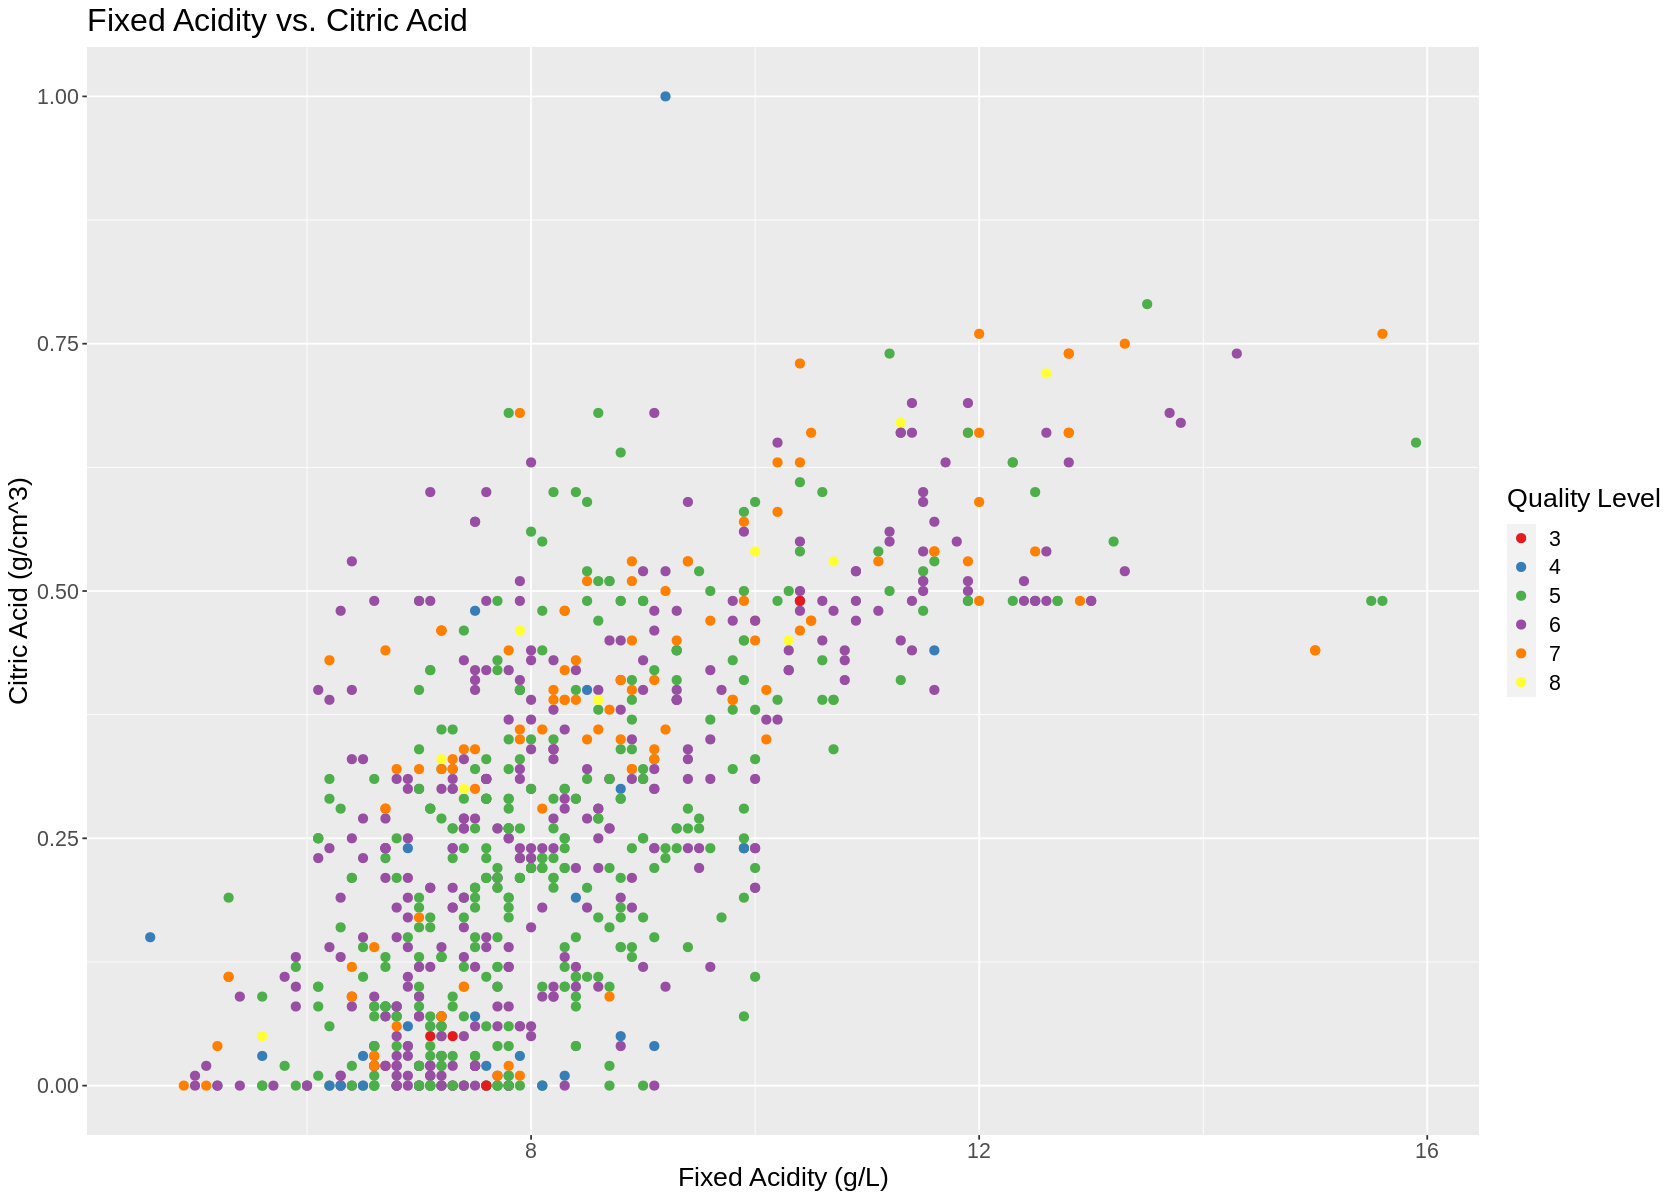

In [18]:
options(repr.plot.width=14, repr.plot.height=10)

# Fixed Acidity vs. Citric Acid
fixed_citric_plot <- training_data %>%
    ggplot(aes(x=fixed_acidity, y=citric_acid, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="Citric Acid (g/cm^3)", color = "Quality Level")+
    ggtitle("Fixed Acidity vs. Citric Acid")+
    scale_color_brewer(palette = "Set1")

fixed_citric_plot

**Fig 2d. pH VS Density**

pH and density seems to have a linear moderately weak positive relationship at r = -0.353.  There does not seem to be a strong connection between quality level when plotted against pH and density.


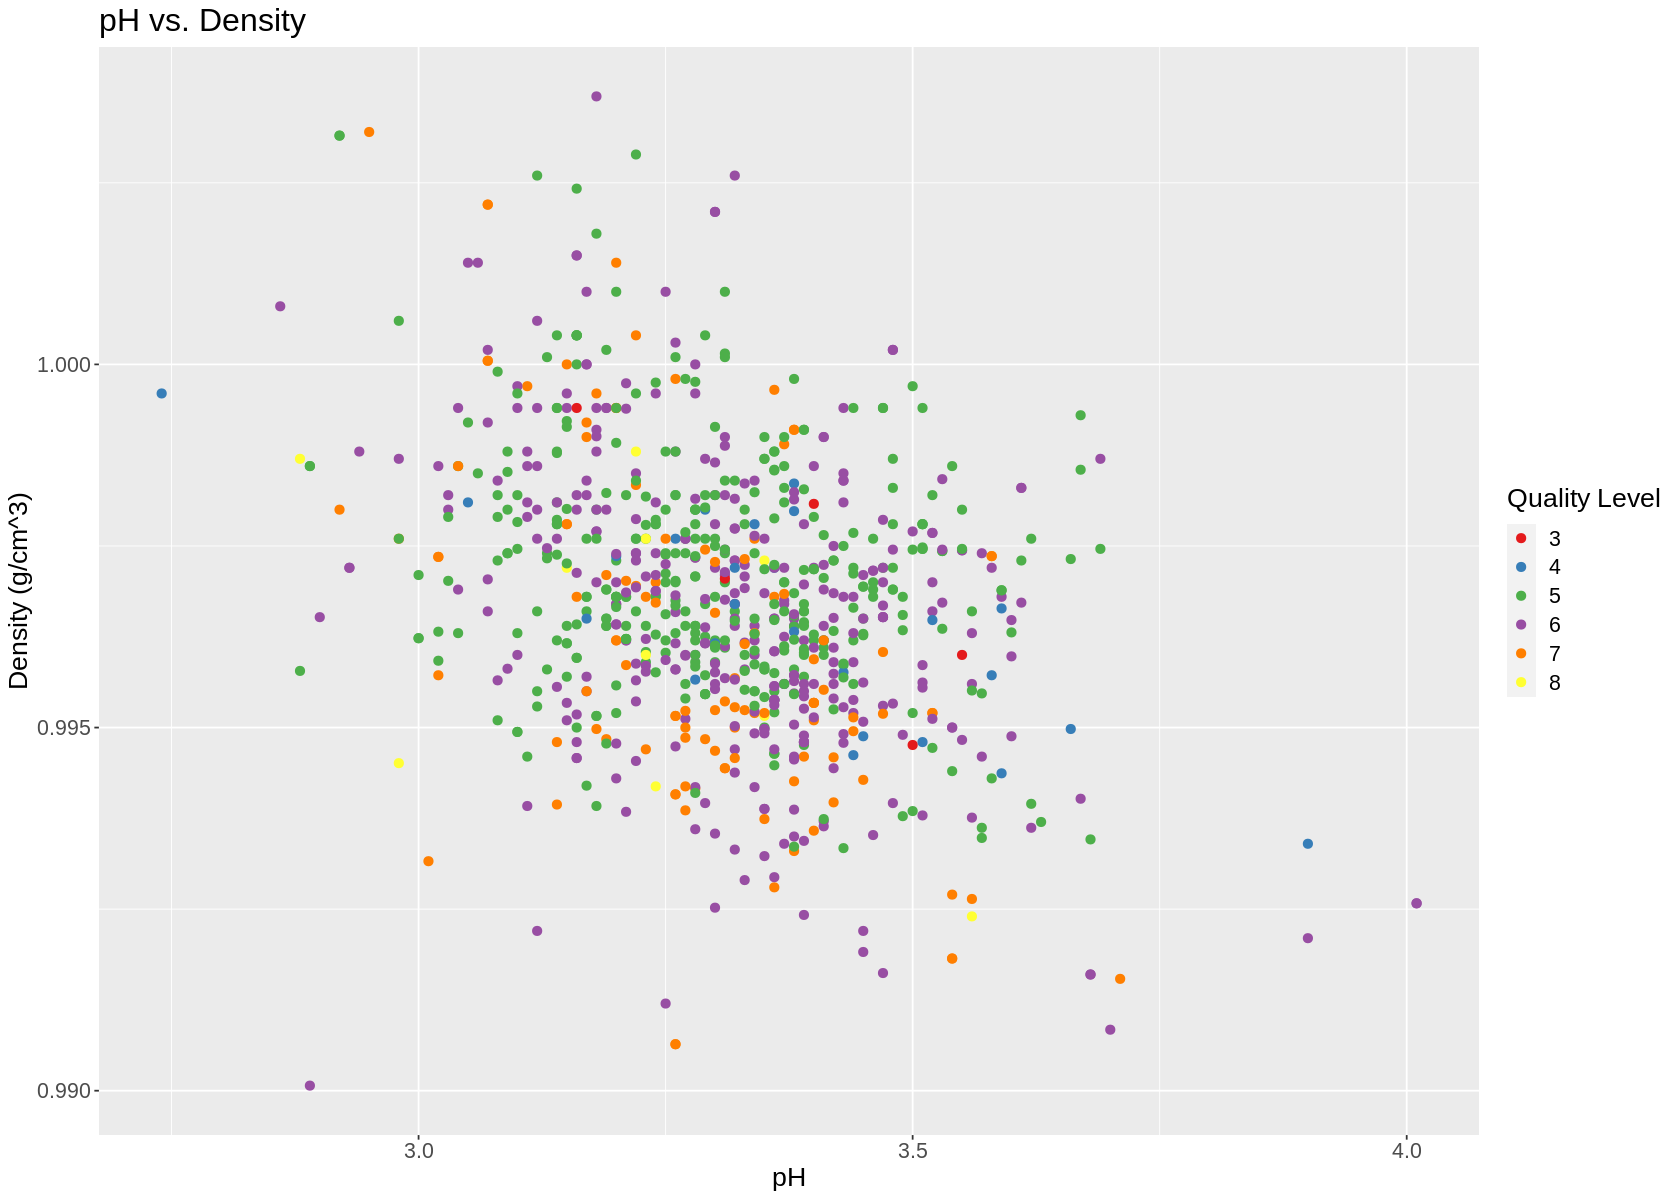

In [42]:
options(repr.plot.width=14, repr.plot.height=10)

# pH vs. Density
pH_density_plot <- training_data %>%
    ggplot(aes(x=pH, y=density, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="pH", y="Density (g/cm^3)", color = "Quality Level")+
    ggtitle("pH vs. Density")+
    scale_color_brewer(palette = "Set1")

pH_density_plot

**Fig 3. Class Distribution**

While there are many wines that were classified into the mid-range of quality levels, there are few observations in the higher and lower levels. The classes are highly imbalanced, which are known to pose an issue to our k-nearest neighbours classification.

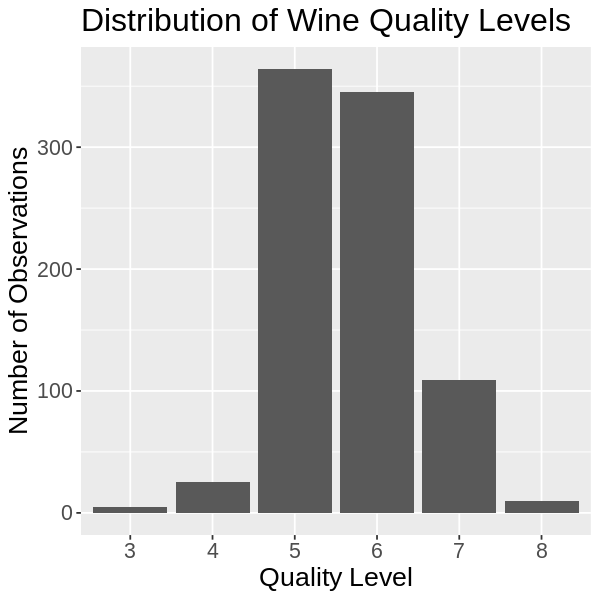

In [51]:
options(repr.plot.width=5, repr.plot.height=5)

class_dist_plot <- training_data %>%
    count(quality) %>%
    ggplot(aes(x=quality, y=n)) +
    geom_bar(stat="identity") +
    labs(x= "Quality Level", y= "Number of Observations") +
    ggtitle("Distribution of Wine Quality Levels") +
    theme(text = element_text(size = 16)) +
    scale_color_brewer(palette = "Set1")

class_dist_plot
# ggplot(data = training_data, aes(x=quality, y=)

From there, we performed classification by creating a recipe and workflow and fitting the model to the data. In addition, a confusion matrix was added to test how many observations were predicted correctly. We then calculated the accuracy of the model to predict the wine quality of observations on the testing data. Cross-validation with 10 folds was then performed and the model was tuned. We found that k=2 provided us the highest accuracy, seen in Figure 5.


In [24]:
set.seed(2341)
wine_recipe <- recipe(quality ~ pH + density + fixed_acidity + citric_acid , data = training_data) %>%
    step_scale(all_predictors()) %>%
    step_scale(all_predictors())
wine_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Scaling for all_predictors()

In [25]:
set.seed(2341)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_spec

knn_fit <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = training_data)

knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5128205
Best kernel: rectangular
Best k: 3

In [26]:
set.seed(2341) # DO NOT REMOVE

wine_test_predictions <- predict(knn_fit , testing_data) %>%
       bind_cols(testing_data)


wine_test_predictions

.pred_class,fixed_acidity,citric_acid,density,pH,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,7.9,0.06,0.9964,3.30,5
5,8.5,0.56,0.9969,3.30,7
5,8.3,0.12,0.9966,3.17,5
5,5.2,0.25,0.9957,3.38,5
5,7.5,0.20,0.9968,3.21,6
5,8.8,0.26,0.9971,3.15,5
6,8.6,0.36,0.9970,3.20,5
6,10.2,0.57,0.9971,3.04,5
6,8.8,0.40,0.9980,3.44,5


In [27]:
set.seed(2341) # DO NOT REMOVE

wine_prediction_accuracy <- wine_test_predictions %>%
        metrics(truth = quality, estimate = .pred_class) %>%
        filter(.metric == "accuracy")

wine_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4912281


**Fig 4. Confusion Matrix**

The confusion matrix shows that the classifier labeled a total of 140 observations correctly out of a total of 285 observations. A majority of misclassifications made were within 1 quality level from the true level.


In [28]:
set.seed(2341) # DO NOT REMOVE

wine_mat <- wine_test_predictions %>% 
       conf_mat(truth = quality, estimate = .pred_class)

" Quality is best at quality =8 , and it average at quality = 5 , and its a poor quality wine when quality = 3"
wine_mat

[1] " Quality is best at quality =8 , and it average at quality = 5 , and its a poor quality wine when quality = 3"

          Truth
Prediction  3  4  5  6  7  8
         3  0  0  0  0  0  0
         4  0  0  1  4  0  0
         5  0  6 71 49  7  0
         6  1  2 38 52  7  2
         7  0  0  8 11 17  4
         8  0  0  1  1  3  0

In [29]:
set.seed(2341) # DO NOT REMOVE

wine_vfold <- vfold_cv(training_data, v = 10, strata = quality)



In [30]:
set.seed(2341) # DO NOT REMOVE

wine_resample_fit <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_spec) %>%
       fit_resamples(resamples = wine_vfold)


! Fold02: internal: No observations were detected in `truth` for level(s): '3', '8...

! Fold03: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold04: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold05: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold06: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold08: internal: No observations were detected in `truth` for level(s): '3', '8...



In [31]:
wine_metrics <- wine_resample_fit %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")
wine_metrics

accuracy <- wine_metrics %>%
    select(mean) %>%
    pull(1)

accuracy

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.4952682,10,0.01183203


[1] 0.4952682

In [32]:
set.seed(2341) # DO NOT REMOVE
knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [33]:
set.seed(1234) # set the seed, don't remove this

knn_results <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = wine_vfold, grid = 10) %>%
       collect_metrics() %>%
       filter(.metric == "accuracy")


knn_results

! Fold02: internal: No observations were detected in `truth` for level(s): '3', '8...

! Fold03: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold04: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold05: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold06: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold08: internal: No observations were detected in `truth` for level(s): '3', '8...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5070348,10,0.010266104,Model01
3,accuracy,multiclass,0.4952682,10,0.011832026,Model02
4,accuracy,multiclass,0.4860588,10,0.009608555,Model03
5,accuracy,multiclass,0.4802022,10,0.012370327,Model04
7,accuracy,multiclass,0.4745890,10,0.010663444,Model05
9,accuracy,multiclass,0.4848390,10,0.009253803,Model06
10,accuracy,multiclass,0.4779708,10,0.011582725,Model07
12,accuracy,multiclass,0.4908048,10,0.010462769,Model08
13,accuracy,multiclass,0.4931583,10,0.012480246,Model09


**Fig 5. Accuracy VS k**

The line plot comparing accuracy estimates against k neighbors demonstrates that the optimal k value was placed at 2 since the maximum accuracy estimate was at that point and we see that it is the “elbow” of the plot, where the accuracy starts to mostly decrease at a slower rate as k increases. It is important to note that there is a resurgence at k = 10, where accuracy estimates increase with increased neighbors up to k = 14.


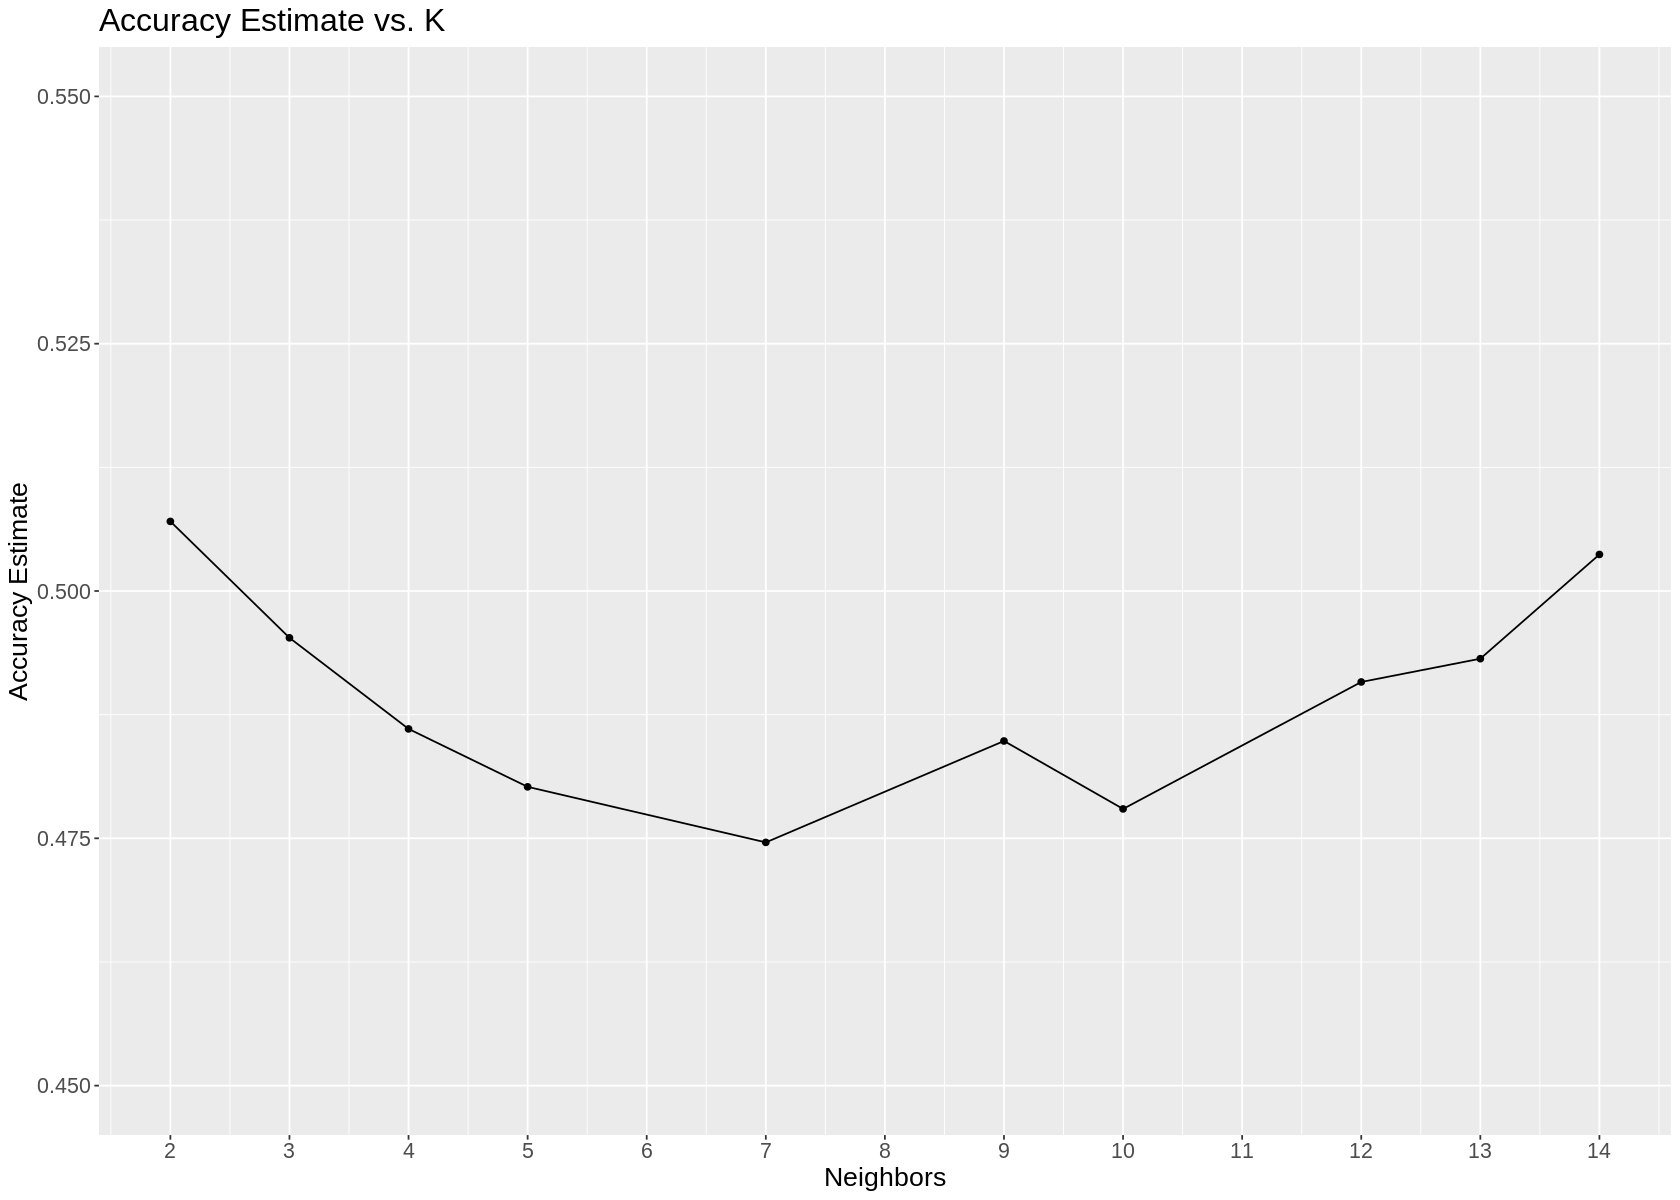

In [34]:
accuracies <- knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       theme(text = element_text(size = 16)) +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy Estimate vs. K") +
       scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.45, 0.55)) # adjusting the y-axis


accuracy_versus_k

In [35]:
set.seed(2341)

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
       set_engine("kknn") %>%
       set_mode("classification")
wine_spec

wine_fit <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = training_data)

wine_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 2
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5128205
Best kernel: rectangular
Best k: 3

In [36]:
# mean and sd for all predictor variables (not divided by class)
predictor_summary <- training_data %>%
    select(fixed_acidity:pH) %>%
    gather("predictor", "values") %>%
    group_by(predictor) %>%
    summarize(mean = mean(values), sd = sd(values))

predictor_summary

`summarise()` ungrouping output (override with `.groups` argument)



predictor,mean,sd
<chr>,<dbl>,<dbl>
citric_acid,0.2661072,0.195212233
density,0.9967537,0.001958048
fixed_acidity,8.3306527,1.770002813
pH,3.3088811,0.157801871


In [37]:
final_predictions <- predict(wine_fit , testing_data) %>%
       bind_cols(testing_data)
final_model_accuracy <- final_predictions %>%
        metrics(truth = quality, estimate = .pred_class) %>%
        filter(.metric == "accuracy") %>%
        select(.estimate) %>%
        pull(1)
final_model_accuracy


[1] 0.4912281

**Figure 6. Actual VS Predicted Wine Quality for Predictor Variables**

The actual and predicted qualities for our predictor variables deviated quite a bit. Notably, a decent amount of the predicted values are inaccurate, however the majority of those mispredictions are only 1 quality level above or below the actual value. This is consistent with our accuracy of 0.49, which means that around half of our predictions will be correctly classified. Furthermore, the matrix also helped conclude that half of the predictors were classified by an error of 1 quality level (Fig 4.).


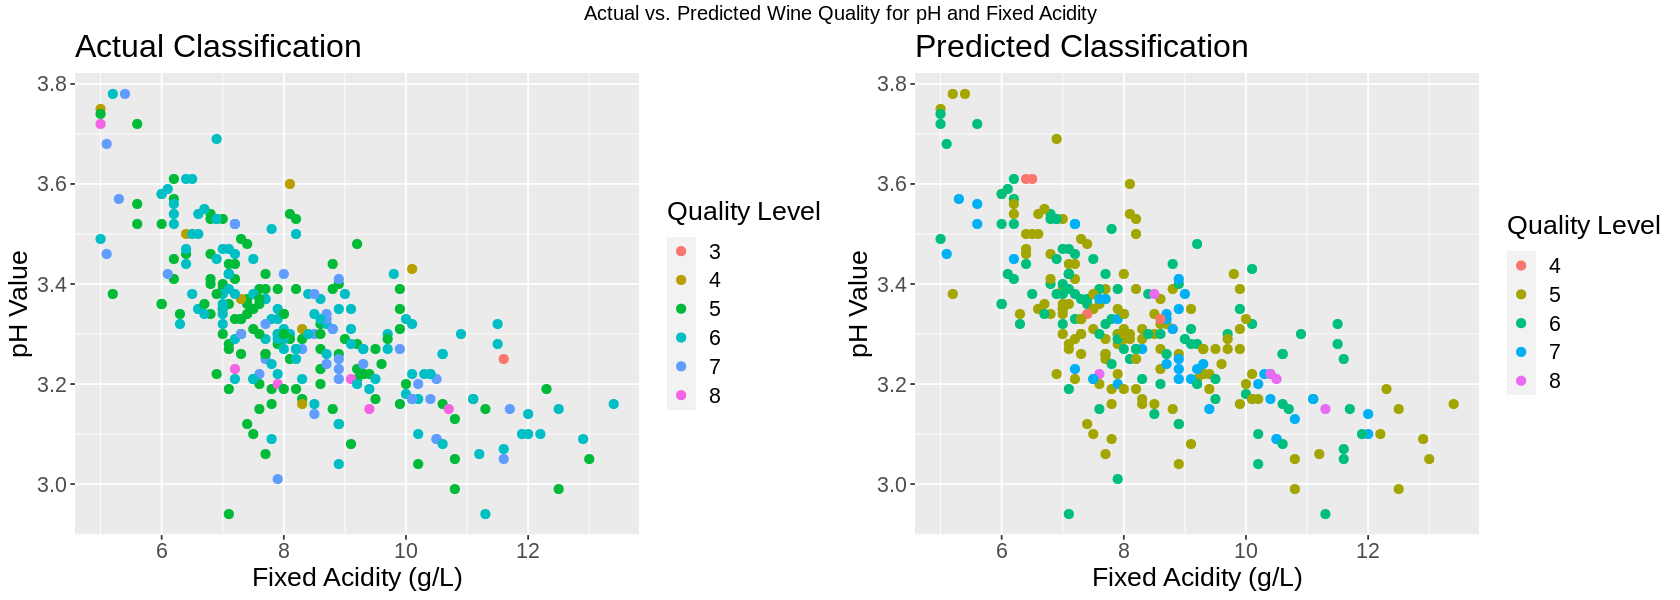

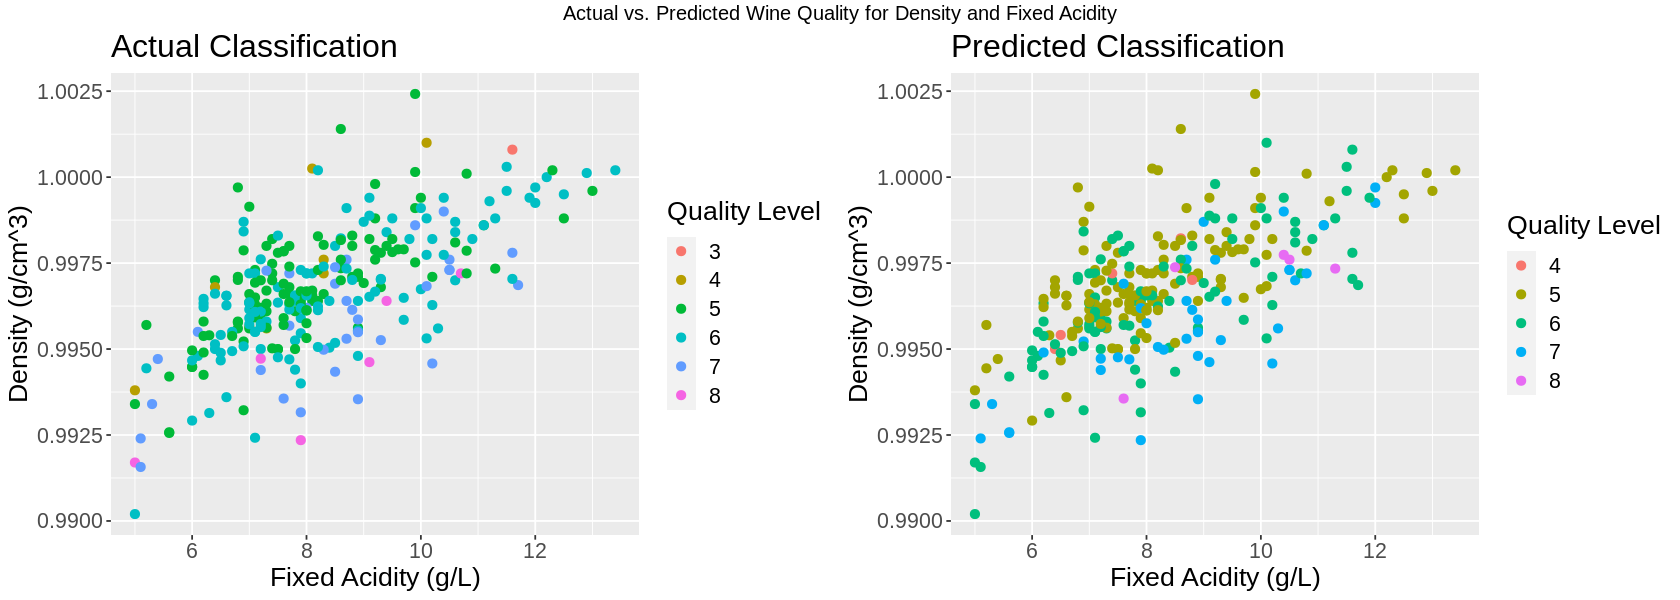

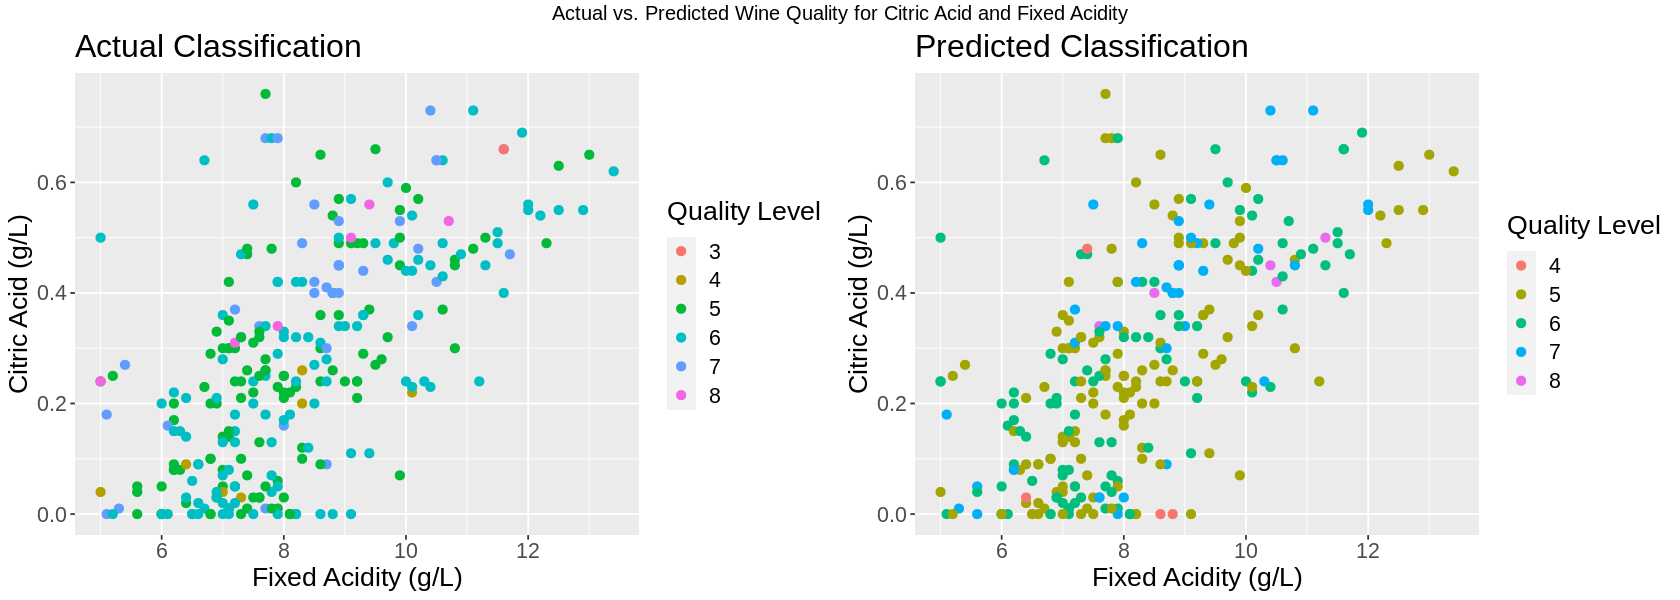

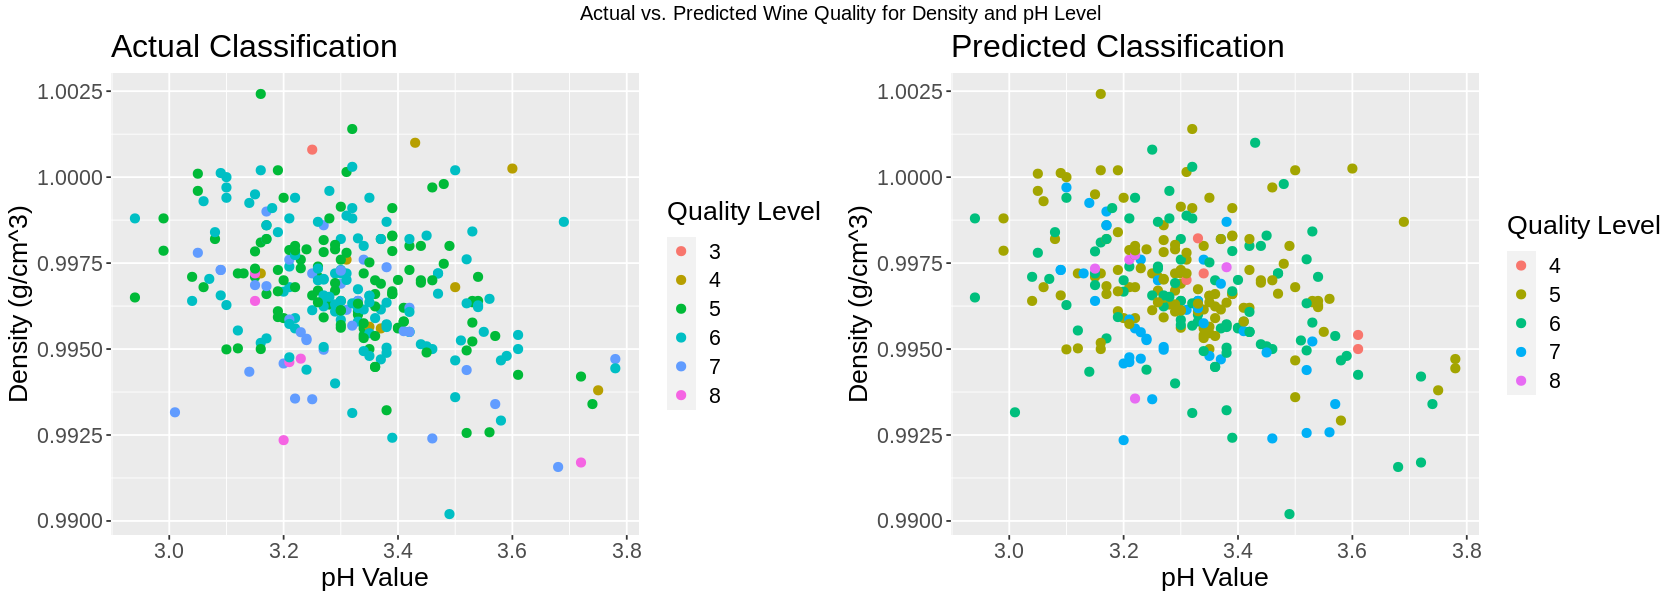

In [38]:
options(repr.plot.width=14, repr.plot.height=5)

acidity_pH_actual <- final_predictions %>%
    ggplot(aes(x=fixed_acidity, y=pH, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="pH Value", color = "Quality Level")+
    ggtitle("Actual Classification")
acidity_pH_predicted <- final_predictions %>%
    ggplot(aes(x=fixed_acidity, y=pH, color=.pred_class)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="pH Value", color = "Quality Level")+
    ggtitle("Predicted Classification")
grid.arrange(grobs = list(acidity_pH_actual, acidity_pH_predicted), top= "Actual vs. Predicted Wine Quality for pH and Fixed Acidity", ncol=2)

acidity_density_actual <- final_predictions %>%
    ggplot(aes(x=fixed_acidity, y=density, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="Density (g/cm^3)", color = "Quality Level")+
    ggtitle("Actual Classification")
acidity_density_predicted <- final_predictions %>%
    ggplot(aes(x=fixed_acidity, y=density, color=.pred_class)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="Density (g/cm^3)", color = "Quality Level")+
    ggtitle("Predicted Classification")
grid.arrange(grobs = list(acidity_density_actual, acidity_density_predicted), top= "Actual vs. Predicted Wine Quality for Density and Fixed Acidity", ncol=2)

acidity_citric_actual <- final_predictions %>%
    ggplot(aes(x=fixed_acidity, y=citric_acid, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="Citric Acid (g/L)", color = "Quality Level")+
    ggtitle("Actual Classification")
acidity_citric_predicted <- final_predictions %>%
    ggplot(aes(x=fixed_acidity, y=citric_acid, color=.pred_class)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="Citric Acid (g/L)", color = "Quality Level")+
    ggtitle("Predicted Classification")
grid.arrange(grobs = list(acidity_citric_actual, acidity_citric_predicted), top= "Actual vs. Predicted Wine Quality for Citric Acid and Fixed Acidity", ncol=2)

pH_density_actual <- final_predictions %>%
    ggplot(aes(x=pH, y=density, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="pH Value", y="Density (g/cm^3)", color = "Quality Level")+
    ggtitle("Actual Classification")
pH_density_predicted <- final_predictions %>%
    ggplot(aes(x=pH, y=density, color=.pred_class)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="pH Value", y="Density (g/cm^3)", color = "Quality Level")+
    ggtitle("Predicted Classification")
grid.arrange(grobs = list(pH_density_actual, pH_density_predicted), top= "Actual vs. Predicted Wine Quality for Density and pH Level", ncol=2)

### Discussion

We found that our model was able to predict wine quality using k-nearest neighbour classification based on measurements of fixed acidity, pH, density, and citric acid level with an accuracy of 49%. This was expected, as it is consistent with some other studies predicting wine quality from similar predictors using other methods which achieved accuracies of 0.45 using various machine learning methods including neuron network and multiple regression (Cortez  et al., 2009). However, compared to some other studies which used other methods of classification, such as Chiu et al. (2021) who used support vector machine and random forest machine learning algorithms to achieve an accuracy of 0.66, we see that there are better ways to classify wine quality from these predictors. The lower accuracy of our model can be explained by the limitation of the unbalanced nature of our classes, as there were many more observations in some classes compared to others, which does not work as well with k-nearest neighbour classification. It is also possible that there are other factors of a red wine, not measured in our data set, that are better predictors of wine quality, such as grape variety and other aspects of the climate in which the grapes are grown.
 
In the future, further research should be done on completing knn classification with other variables such as grape variety and the climate the grapes are grown in. Additional questions could include how we could optimize the data for increased accuracy. To take it further, additional testing can be done on people. Blind tests can be used to judge whether the qualities of our predictors really affect taste. Social tests can also be conducted. Would people trust wine quality determined via computers? What would public perception be of a product that has been historically subjectively judged?


### Conclusion
As a result of using the k-nearest neighbours classification algorithm to classify “Vinho Verde” red wines based on their levels of fixed acidity, citric acid, pH, and density, we were able to create a model that was able to predict wine quality level accurately 49% of the time. This is fairly consistent with past studies that used similar predictors and suggests that in future, wine manufacturers may be able to use these predictors to increase the quality level of their wine more strategically, however other strategies and factors to wine production should be explored more.